# Based on an original script by Google


# Introduction

We are going to create a movie recommendation system using the data sets [MovieLens-100K](https://movielens.org/) available [here](http://grouplens.org/datasets/movielens/).  The data consists of movies ratings (on a scale of 1 to 5).

<br>

## Inicialization

Import required packages

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
from tqdm.notebook import tqdm
import sklearn.manifold
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# tf.logging.set_verbosity(tf.logging.ERROR)
#
import tensorflow as tf

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-hgc5hx9_
  Running command git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-hgc5hx9_
  fatal: unable to connect to github.com:
  github.com[0: 140.82.114.3]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-hgc5hx9_ did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-hgc5hx9_ did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Done installing Altair.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We download the data from Movielens-100K, and save it in a structure. The selected data structure is a DataFrame (general table of contents) that contains the movies, the users, and the ratings that the users associated with the movies.

In [ ]:
# @title Data loading

# Download from the web
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Loading of each of the data sets (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The data structure of the movies follows a binary structure.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Wrap in indices to start at zero (so they match the rows).
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# We evaluate the number of films by genre.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies might have multiple genres assigned to them, let's create several different columns to represent the genres:
# - all_genres: with the list of all the genres that the movie can generate.
# - genre: any one of the possible ones (but only one).
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# We merge all the data into a single table from the selected indexes.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# We separate the data for training and validation (ESSENTIAL for the learning phase).
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
users

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213
...,...,...,...,...,...
938,938,26,F,student,33319
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209


In [ ]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Animation,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Drama,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Drama,Crime-Drama-Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,Drama,Drama
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,1,0,1,0,0,1998,Thriller,Romance-Thriller
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,1,0,0,0,0,1998,Romance,Drama-Romance
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,1994,Comedy,Comedy


In [ ]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.000,881250949
1,185,301,3.000,891717742
2,21,376,1.000,878887116
3,243,50,2.000,880606923
4,165,345,1.000,886397596
...,...,...,...,...
99995,879,475,3.000,880175444
99996,715,203,5.000,879795543
99997,275,1089,1.000,874795795
99998,12,224,2.000,882399156


# Dataset Exploration
Before going any further, you need to get to know the dataset a bit, starting with its fundamental statistics in terms of users, movies, and ratings.

### Users
We extract some basic metrics.

In [ ]:
users.describe()

,age
count,943.000
mean,34.052
std,12.193
min,7.000
25%,25.000
50%,31.000
75%,43.000
max,73.000


Also some basic statistics on the categorical variables that describe the users.

In [ ]:
users.describe(include=[np.object])

<ipython-input-4-81b4aa1c5ed8>:1: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  users.describe(include=[np.object])


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

We can also create milestones to better understand the distribution of users.

In [ ]:
# @title Visualization using the interactive tool Altair
# Emplearemos histogramas organizados según un atributo

# We will use histograms organized according to an attribute
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# Generate histograms from the data and an input filter
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')


Next, we look at the distribution of ratings per user. Clicking on an occupation in the chart to the right will filter the data by that occupation. The corresponding histogram is shown in blue and is overlaid with the histogram of all data (in light grey). You can use SHIFT+click to select multiple subsets.

What do you observe and how might this affect the recommendations?

In [ ]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Crea un gráfico para las ocurrencias, y otro para la media.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### Movies

It is also useful to consult information about movies and their ratings.

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631
120,Independence Day (ID4) (1996),429,3.438


In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


Finally, the last graph shows the distribution of the number of ratings and average rating.




In [ ]:
# Muestra el número de calificaciones y la calificación promedio por película.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# Functions definitions

In [ ]:
du = movies[movies.duplicated(subset=['title'], keep=False)]
print("Filas duplicadas:")
print(du)

movies = movies.drop_duplicates(subset=['title'])
movies['movie_id'] = movies['movie_id'].astype(int)


Filas duplicadas:
     movie_id                          title release_date  video_release_date  \
245       245             Chasing Amy (1997)  01-Jan-1997                 NaN   
265       265      Kull the Conqueror (1997)  29-Aug-1997                 NaN   
267       267             Chasing Amy (1997)  01-Jan-1997                 NaN   
296       296             Ulee's Gold (1997)  01-Jan-1997                 NaN   
302       302             Ulee's Gold (1997)  01-Jan-1997                 NaN   
...       ...                            ...          ...                 ...   
1644     1644        Butcher Boy, The (1998)  01-Jan-1998                 NaN   
1649     1649        Butcher Boy, The (1998)  01-Jan-1998                 NaN   
1653     1653   Chairman of the Board (1998)  01-Jan-1998                 NaN   
1657     1657  Substance of Fire, The (1996)  06-Dec-1996                 NaN   
1679     1679           Sliding Doors (1998)  01-Jan-1998                 NaN   

         

<ipython-input-9-123f72cd6b95>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['movie_id'] = movies['movie_id'].astype(int)


In [ ]:
ratings['movie_id'] = ratings['movie_id'].astype(int)
ratings['user_id'] = ratings['user_id'].astype(int)
ratings.dtypes
ratings

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.000,881250949
1,185,301,3.000,891717742
2,21,376,1.000,878887116
3,243,50,2.000,880606923
4,165,345,1.000,886397596
...,...,...,...,...
99995,879,475,3.000,880175444
99996,715,203,5.000,879795543
99997,275,1089,1.000,874795795
99998,12,224,2.000,882399156


## Histogram

In [ ]:
def cardinality(df, condition):
  ''' Returns the number of rows in table or dataframe holding some condition '''
  return len(df[condition])

def histogram(df, feature):
  ''' Returns the distribution of values for a specified feature '''
  distribution = df[feature].value_counts()

  # Plot the histogram
  plt.figure(figsize=(8, 6))
  plt.bar(distribution.index, distribution.values)
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {feature}')
  plt.show()

  return distribution

Let's try these functions

In [ ]:
age_count = cardinality(users, users['age'] >= 30)
animation_count = cardinality(movies, movies['Animation'] == 1)
high_ratings_count = cardinality(ratings, ratings['rating'] >= 4)

print("Number of users equal or above 30:" + ' ' + str(age_count))
print("Number animation movies:" + ' '+ str(animation_count))
print("Number of ratings equal or above 4:" + ' ' + str(high_ratings_count))

Number of users equal or above 30: 534
Number animation movies: 42
Number of ratings equal or above 4: 55375


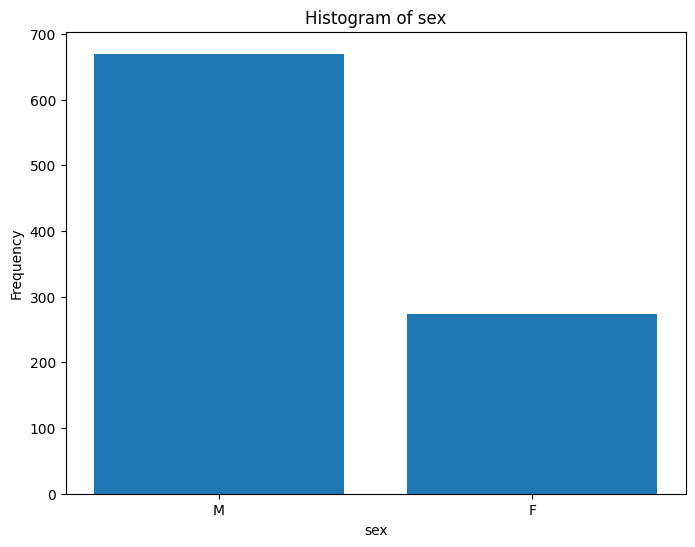

In [ ]:
sex_histogram = histogram(users, 'sex')

## Similarity

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

def similarity(a, b, METRIC):
  if METRIC == 'cosine':
    cos_dist = cosine(a, b)
    return 1 - cos_dist
  elif METRIC == 'pearson':
    return np.corrcoef(a, b)[0, 1]

Now we try this one

In [ ]:
vector_a = np.array([1,2,3])
vector_b = np.array([4,5,6])

cosine_similarity = similarity(vector_a, vector_b, 'cosine')
print("Cosine Similarity:", cosine_similarity)

pearson_coefficient = similarity(vector_a, vector_b, 'pearson')
print("Pearson Coefficient:", pearson_coefficient)

Cosine Similarity: 0.9746318461970761
Pearson Coefficient: 1.0


## k-nearest

In [ ]:
def neighbors(A, b, METRIC, k):
    # Similarities scores
    similarities = []

    # Lets calculate the similarity between the vector b and the vector of the A matrix
    for i, a in enumerate(A):
        if METRIC == 'cosine':
            similarity_score = similarity(a, b, METRIC)
        elif METRIC == 'pearson':
            similarity_score = similarity(a, b, METRIC)

        similarities.append((i, similarity_score))
        # print(similarities)

    # Sort the similarities by score
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Lets select the k nearest neighbors
    k_nearest = [index for index, _ in similarities[:k]]
    # print(similarities[:k])

    return k_nearest

### k-nearest (DataFrame edition)

Warning! Just run this if you are fully working with dataframes

In [ ]:
def neighbors(A, b, METRIC, k):
    # Ensure b is a pandas Series
    if isinstance(b, pd.DataFrame):
        b = b.iloc[0]

    # Similarities scores
    similarities = []

    # Calculate the similarity between the vector b and the vectors of the A dataframe
    for index, row in A.iterrows():
        similarity_score = similarity(row.values, b.values, METRIC)
        similarities.append((index, similarity_score))

    # Sort the similarities by score
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Select the k nearest neighbors
    k_nearest = [index for index, _ in similarities[:k]]
    print(similarities[:k])

    return k_nearest


Finally this one.
It returns the result metric (0.956), between 'b' and 'A(0)'

In [ ]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = np.array([0, 1, 2])
METRIC = 'cosine'
k = 2
nearest = neighbors(A, b, METRIC, k)
nearest

[0, 1]

# Content-based filtering

## Explore items
Returns the number of items per genre

In [ ]:
def exploreitems(movies):
    total_count = 0

    genre_counts = movies.drop(columns=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'year', 'genre', 'all_genres']).sum()

    # print("Number of items per genre:")

    genre_list = []

    for genre, count in genre_counts.items():
        # print(f"{genre}: {count}")
        total_count += count
        genre_list.append([genre, str(count)])

    # print("Total number of items:", total_count)

    genre_array = np.array(genre_list, dtype=object)

    return genre_array

In [ ]:
exploreitems(movies)

array([['genre_unknown', '2'],
       ['Action', '249'],
       ['Adventure', '133'],
       ['Animation', '42'],
       ['Children', '120'],
       ['Comedy', '502'],
       ['Crime', '107'],
       ['Documentary', '50'],
       ['Drama', '716'],
       ['Fantasy', '22'],
       ['Film-Noir', '24'],
       ['Horror', '90'],
       ['Musical', '56'],
       ['Mystery', '60'],
       ['Romance', '244'],
       ['Sci-Fi', '100'],
       ['Thriller', '248'],
       ['War', '71'],
       ['Western', '27']], dtype=object)

## Filtering task


In [ ]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Children,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Action,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1676,Sweet Nothing (1995),20-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Sweet%20Nothi...,0,0,0,0,0,...,0,0,0,0,0,0,0,1996,Drama,Drama
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,Drama,Drama
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,1,0,1,0,0,1998,Thriller,Romance-Thriller
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,1994,Comedy,Comedy


### Unary Matrix

There are two ways of performing the unary matrix

1.   Directly droping all columns except the ones with genre categories
2.   Performing a new one-hot encoding alike matrix attending to the column 'genre'



In [ ]:
# First way
genre_categories = movies.drop(columns=['title', 'release_date', 'video_release_date', 'imdb_url', 'year', 'genre', 'all_genres'])
genre_unary_df = pd.DataFrame(genre_categories)
genre_unary_df

,movie_id,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1676,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1677,1677,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1680,1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Second way
genres_head = genre_categories.columns
# Empty unary matrix
genres_matrix = np.zeros(genre_unary_df.shape)

# for row_i, column_j in enumerate(genres_matrix):
  # print(row_i)
  # print(column_j)
  #genres_matrix[row_i, 0] = row_i
  # genres_matrix.where(movies.genre == genres_head)[row_i] = 1

for row_i, full_row_i in enumerate(genres_matrix):
  genres_matrix[row_i, 0] = row_i
  for pos_j, genre in enumerate(genres_head):
    if movies.genre.iloc[row_i] == genre:
      genres_matrix[row_i, pos_j] = 1

genre_unary_df_2 = pd.DataFrame(genres_matrix, columns=genres_head)
genre_unary_df_2

,movie_id,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
3,3.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,4.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,1659.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1660,1660.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1661,1661.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1662,1662.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### "contentfiltering" function

In [ ]:
def contentfiltering(movies_unary, metric='cosine', k_n=5):
    result_matrix = np.zeros((movies_unary.shape[0], k_n+1))
    k_n += 1
    A_mtx = movies_unary.values[:, 1:]
    for row_i in range(0, movies_unary.shape[0]):
      result_matrix[row_i, 0] = movies_unary.iloc[row_i, 0]
      # A_mtx = np.delete(movies_unary.values, row_i, axis=0)[:, 1:]
      full_row = movies_unary.iloc[row_i, 1:].values
      result_matrix[row_i, 0] = movies_unary.iloc[row_i, 0]
      # print(result_matrix[row_i, 0])
      # result_matrix[row_i, 1:] = neighbors(A_mtx, full_row, metric, k_n)[1:]
      result_row = neighbors(A_mtx, full_row, metric, k_n)
      print(result_row)
      result_matrix[row_i, 1:] = result_row[1:]
    return result_matrix

In [ ]:
result_content_1 = contentfiltering(genre_unary_df, 'cosine', int(5))

[0, 418, 94, 1209, 62, 93]
[1, 116, 117, 561, 820, 921]
[2, 197, 217, 355, 462, 590]
[3, 73, 1128, 33, 44, 46]
[4, 99, 326, 329, 644, 1059]
[5, 8, 14, 17, 18, 29]
[6, 257, 425, 996, 238, 268]
[7, 835, 33, 44, 46, 62]
[5, 8, 14, 17, 18, 29]
[9, 156, 179, 189, 198, 204]
[10, 11, 155, 333, 357, 578]
[10, 11, 155, 333, 357, 578]
[12, 24, 25, 39, 40, 41]
[13, 19, 35, 124, 130, 196]
[5, 8, 14, 17, 18, 29]
[15, 48, 65, 69, 80, 82]
[16, 271, 392, 1129, 28, 182]
[5, 8, 14, 17, 18, 29]
[5, 8, 14, 17, 18, 29]
[13, 19, 35, 124, 130, 196]
[20, 1, 116, 117, 185, 358]
[21, 187, 323, 510, 646, 796]
[22, 42, 43, 76, 97, 105]
[23, 253, 571, 28, 230, 399]
[12, 24, 25, 39, 40, 41]
[12, 24, 25, 39, 40, 41]
[26, 232, 262, 359, 393, 451]
[27, 53, 243, 908, 1015, 1480]
[28, 230, 23, 253, 395, 571]
[5, 8, 14, 17, 18, 29]
[30, 244, 9, 22, 42, 43]
[31, 47, 74, 114, 118, 317]
[32, 67, 563, 741, 744, 1079]
[33, 44, 46, 64, 92, 149]
[34, 77, 453, 1595, 131, 111]
[13, 19, 35, 124, 130, 196]
[5, 8, 14, 17, 18, 29]
[3

Let's analyzed the obtained results

In [ ]:
result_content_1

array([[0.000e+00, 4.180e+02, 9.400e+01, 1.209e+03, 6.200e+01, 9.300e+01],
       [1.000e+00, 1.160e+02, 1.170e+02, 5.610e+02, 8.200e+02, 9.210e+02],
       [2.000e+00, 1.970e+02, 2.170e+02, 3.550e+02, 4.620e+02, 5.900e+02],
       ...,
       [1.678e+03, 8.770e+02, 1.661e+03, 3.200e+01, 6.700e+01, 8.900e+01],
       [1.680e+03, 2.400e+01, 2.500e+01, 3.900e+01, 4.000e+01, 4.100e+01],
       [1.681e+03, 8.000e+00, 1.400e+01, 1.700e+01, 1.800e+01, 2.900e+01]])

In [ ]:
result_mtx_names = np.empty(result_content_1.shape, dtype=object)

for row in range(result_content_1.shape[0]):
    for movie in range(result_content_1.shape[1]):
        movie_id = result_content_1[row, movie]
        # Encontrar el título de la película correspondiente
        moviename = movies[movies['movie_id'] == movie_id]['title'].values
        # Asignar el título de la película a la matriz result_mtx_names
        result_mtx_names[row, movie] = moviename
result_mtx_names

array([[array(['Toy Story (1995)'], dtype=object),
        array(['Mary Poppins (1964)'], dtype=object),
        array(['Aladdin (1992)'], dtype=object),
        array(['Virtuosity (1995)'], dtype=object),
        array(['Santa Clause, The (1994)'], dtype=object),
        array(['Home Alone (1990)'], dtype=object)],
       [array(['GoldenEye (1995)'], dtype=object),
        array(['Rock, The (1996)'], dtype=object),
        array(['Twister (1996)'], dtype=object),
        array(['Quick and the Dead, The (1995)'], dtype=object),
        array(['Mrs. Winterbourne (1996)'], dtype=object),
        array(['Dead Man (1995)'], dtype=object)],
       [array(['Four Rooms (1995)'], dtype=object),
        array(['Nikita (La Femme Nikita) (1990)'], dtype=object),
        array(['Cape Fear (1991)'], dtype=object),
        array(['Client, The (1994)'], dtype=object),
        array(['Secret of Roan Inish, The (1994)'], dtype=object),
        array(['Primal Fear (1996)'], dtype=object)],
       ...,
 

Results dataframe

In [ ]:
result_content_df = pd.DataFrame(result_mtx_names, columns=['Movie'] + [f'Recommendation {i+1}' for i in range(result_mtx_names.shape[1] - 1)])
result_content_df

,Movie,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,[Toy Story (1995)],[Mary Poppins (1964)],[Aladdin (1992)],[Virtuosity (1995)],"[Santa Clause, The (1994)]",[Home Alone (1990)]
1,[GoldenEye (1995)],"[Rock, The (1996)]",[Twister (1996)],"[Quick and the Dead, The (1995)]",[Mrs. Winterbourne (1996)],[Dead Man (1995)]
2,[Four Rooms (1995)],[Nikita (La Femme Nikita) (1990)],[Cape Fear (1991)],"[Client, The (1994)]","[Secret of Roan Inish, The (1994)]",[Primal Fear (1996)]
3,[Get Shorty (1995)],[Faster Pussycat! Kill! Kill! (1965)],[Chungking Express (1994)],"[Doom Generation, The (1995)]",[Eat Drink Man Woman (1994)],[Ed Wood (1994)]
4,[Copycat (1995)],[Fargo (1996)],[Cop Land (1997)],[187 (1997)],[Paris Is Burning (1990)],"[Adventures of Pinocchio, The (1996)]"
...,...,...,...,...,...,...
1659,[Sweet Nothing (1995)],[Dead Man Walking (1995)],[Mr. Holland's Opus (1995)],"[White Balloon, The (1995)]",[Antonia's Line (1995)],[Belle de jour (1967)]
1660,[Mat' i syn (1997)],[Dead Man Walking (1995)],[Mr. Holland's Opus (1995)],"[White Balloon, The (1995)]",[Antonia's Line (1995)],[Belle de jour (1967)]
1661,[B. Monkey (1998)],[That Darn Cat! (1997)],[Rough Magic (1995)],[Desperado (1995)],"[Crow, The (1994)]",[So I Married an Axe Murderer (1993)]
1662,[You So Crazy (1994)],"[Birdcage, The (1996)]","[Brothers McMullen, The (1995)]","[To Wong Foo, Thanks for Everything! Julie New...",[Billy Madison (1995)],[Clerks (1994)]


In [ ]:
result_mtx_pearson = contentfiltering(genre_unary_df, 'pearson', int(5))

[0, 418, 94, 1209, 101, 400]
[1, 116, 117, 561, 820, 921]
[2, 197, 217, 355, 462, 590]
[3, 73, 1128, 33, 44, 46]
[4, 99, 326, 329, 644, 1059]
[5, 8, 14, 17, 18, 29]
[6, 257, 425, 996, 238, 268]
[7, 835, 33, 44, 46, 62]
[5, 8, 14, 17, 18, 29]
[9, 156, 179, 189, 198, 204]
[10, 11, 155, 333, 357, 578]
[10, 11, 155, 333, 357, 578]
[12, 24, 25, 39, 40, 41]
[13, 19, 35, 124, 130, 196]
[5, 8, 14, 17, 18, 29]
[15, 48, 65, 69, 80, 82]
[16, 271, 1129, 392, 119, 122]
[5, 8, 14, 17, 18, 29]
[5, 8, 14, 17, 18, 29]
[13, 19, 35, 124, 130, 196]
[20, 1, 116, 117, 561, 820]
[21, 187, 323, 510, 646, 796]
[22, 42, 43, 76, 97, 105]
[23, 253, 571, 28, 230, 399]
[12, 24, 25, 39, 40, 41]
[12, 24, 25, 39, 40, 41]
[26, 232, 262, 359, 393, 451]
[27, 53, 243, 908, 1015, 1480]
[28, 230, 23, 253, 395, 571]
[5, 8, 14, 17, 18, 29]
[30, 244, 22, 42, 43, 76]
[31, 47, 74, 114, 118, 317]
[32, 67, 563, 741, 744, 1079]
[33, 44, 46, 64, 92, 149]
[34, 77, 453, 1595, 131, 111]
[13, 19, 35, 124, 130, 196]
[5, 8, 14, 17, 18, 29

In [ ]:
result_mtx_names_pearson = np.empty(result_mtx_pearson.shape, dtype=object)

for row in range(result_mtx_names_pearson.shape[0]):
    for movie in range(result_mtx_names_pearson.shape[1]):
        movie_id = result_mtx_pearson[row, movie]
        # Encontrar el título de la película correspondiente
        moviename = movies[movies['movie_id'] == movie_id]['title'].values
        # Asignar el título de la película a la matriz result_mtx_names
        result_mtx_names_pearson[row, movie] = moviename
result_mtx_names_pearson

array([[array(['Toy Story (1995)'], dtype=object),
        array(['Mary Poppins (1964)'], dtype=object),
        array(['Aladdin (1992)'], dtype=object),
        array(['Virtuosity (1995)'], dtype=object),
        array(['Aristocats, The (1970)'], dtype=object),
        array(['Brady Bunch Movie, The (1995)'], dtype=object)],
       [array(['GoldenEye (1995)'], dtype=object),
        array(['Rock, The (1996)'], dtype=object),
        array(['Twister (1996)'], dtype=object),
        array(['Quick and the Dead, The (1995)'], dtype=object),
        array(['Mrs. Winterbourne (1996)'], dtype=object),
        array(['Dead Man (1995)'], dtype=object)],
       [array(['Four Rooms (1995)'], dtype=object),
        array(['Nikita (La Femme Nikita) (1990)'], dtype=object),
        array(['Cape Fear (1991)'], dtype=object),
        array(['Client, The (1994)'], dtype=object),
        array(['Secret of Roan Inish, The (1994)'], dtype=object),
        array(['Primal Fear (1996)'], dtype=object)],
   

In [ ]:
result_content_df_pearson = pd.DataFrame(result_mtx_names_pearson, columns=['Movie'] + [f'Recommendation {i+1}' for i in range(result_mtx_names.shape[1] - 1)])
result_content_df_pearson

,Movie,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,[Toy Story (1995)],[Mary Poppins (1964)],[Aladdin (1992)],[Virtuosity (1995)],"[Aristocats, The (1970)]","[Brady Bunch Movie, The (1995)]"
1,[GoldenEye (1995)],"[Rock, The (1996)]",[Twister (1996)],"[Quick and the Dead, The (1995)]",[Mrs. Winterbourne (1996)],[Dead Man (1995)]
2,[Four Rooms (1995)],[Nikita (La Femme Nikita) (1990)],[Cape Fear (1991)],"[Client, The (1994)]","[Secret of Roan Inish, The (1994)]",[Primal Fear (1996)]
3,[Get Shorty (1995)],[Faster Pussycat! Kill! Kill! (1965)],[Chungking Express (1994)],"[Doom Generation, The (1995)]",[Eat Drink Man Woman (1994)],[Ed Wood (1994)]
4,[Copycat (1995)],[Fargo (1996)],[Cop Land (1997)],[187 (1997)],[Paris Is Burning (1990)],"[Adventures of Pinocchio, The (1996)]"
...,...,...,...,...,...,...
1659,[Sweet Nothing (1995)],[Dead Man Walking (1995)],[Mr. Holland's Opus (1995)],"[White Balloon, The (1995)]",[Antonia's Line (1995)],[Belle de jour (1967)]
1660,[Mat' i syn (1997)],[Dead Man Walking (1995)],[Mr. Holland's Opus (1995)],"[White Balloon, The (1995)]",[Antonia's Line (1995)],[Belle de jour (1967)]
1661,[B. Monkey (1998)],[That Darn Cat! (1997)],[Rough Magic (1995)],[Desperado (1995)],"[Crow, The (1994)]",[Tales from the Hood (1995)]
1662,[You So Crazy (1994)],"[Birdcage, The (1996)]","[Brothers McMullen, The (1995)]","[To Wong Foo, Thanks for Everything! Julie New...",[Billy Madison (1995)],[Clerks (1994)]


# Collaborative filtering

## Explore ratings

In [ ]:
def exploreratings(ratings):
    if not {'user_id', 'movie_id', 'rating'}.issubset(ratings.columns):
        raise ValueError("DataFrame must contain 'user_id', 'movie_id', and 'rating' columns.")

    num_users = ratings['user_id'].nunique()
    num_items = ratings['movie_id'].nunique()
    rating_count = ratings.shape[0]

    # Print the results
    print(f"Number of ratings: {rating_count}")
    print(f"Number of movies: {num_items}")
    print(f"Number of users: {num_users}")

    # Get the list of unique user_ids who have rated
    user_ids = ratings['user_id'].unique().tolist()

    return user_ids

In [ ]:
ratings_explored = exploreratings(ratings)

Number of ratings: 100000
Number of movies: 1682
Number of users: 943


In [ ]:
type(ratings_explored)

list

## Filtering task

### Unary matrix

In [ ]:
rating_values = np.arange(1, 5.5, 0.5)

# Round the second decimal
rounded_ratings = np.round(movies_ratings['rating mean'] * 2) / 2

# Create the unary matrix
ratings_matrix = np.zeros((len(movies_ratings), len(rating_values)))

# We iterate and we assign a one
for i, mean_rating in enumerate(rounded_ratings):
    rating_index = np.where(rating_values == mean_rating)[0]
    if len(rating_index) > 0:
        ratings_matrix[i, rating_index[0]] = 1

# print(ratings_matrix)
ratings_unary_df = pd.DataFrame(ratings_matrix, columns=rating_values, index=movies_ratings['movie_id'])
ratings_unary_df

,1.000,1.500,2.000,2.500,3.000,3.500,4.000,4.500,5.000
movie_id,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...
1677,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1678,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1679,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000


### Ordered matrix

In [ ]:
ordered_matrix = np.zeros((users.shape[0], movies.shape[0]))
print(str(users.shape[0])+'|'+str(movies.shape[0]))

for user in range(users.shape[0]):
  print(user)
  for movie in range(movies.shape[0]):
    # print('User: '+str(user)+', movie: '+str(movie))
    rating_value = ratings[(ratings['user_id']==user) & (ratings['movie_id']==movie)]['rating'].values
    # print(rating_value)
    if rating_value.size > 0:
      ordered_matrix[user, movie] = int(rating_value[0])
    else:
      ordered_matrix[user, movie] = 0  # Maybe the user 'user_i' did not rate the movie 'movie_j'


943|1682
0


KeyboardInterrupt: 

In [ ]:
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f'User uploaded file "{file_name}" with length {len(uploaded[file_name])} bytes')

import pandas as pd
import io

df_ordered_matrix = pd.read_csv(io.BytesIO(uploaded['ordered_matrix.csv']))

Saving ordered_matrix.csv to ordered_matrix.csv
User uploaded file "ordered_matrix.csv" with length 6287481 bytes


In [ ]:
df_ordered_matrix = pd.read_csv('ordered_matrix.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'ordered_matrix.csv'

In [ ]:
# df_ordered_matrix = pd.DataFrame(ordered_matrix)
df_ordered_matrix

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663
0,0,5.000,3.000,4.000,3.000,3.000,5.000,4.000,1.000,5.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,4,4.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,938,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
939,939,0.000,0.000,0.000,2.000,0.000,0.000,4.000,5.000,3.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
940,940,5.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
941,941,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
df_ordered_matrix.to_csv("ordered_matrix.csv")

In [ ]:
ratings[ratings['user_id']==932].sort_values(by='movie_id')

,user_id,movie_id,rating,unix_timestamp
78925,932,0,3.000,874854294
77114,932,3,3.000,874854383
94830,932,6,4.000,874854190
97329,932,8,3.000,874854402
94800,932,10,4.000,874853899
...,...,...,...,...
84954,932,1109,3.000,874938728
98934,932,1182,3.000,874938596
87633,932,1187,1.000,874938474
83690,932,1227,1.000,874939247


### "collaborativefiltering" function

In [ ]:
def collaborativefiltering(movies_unary, metric='cosine', k_n=5):
# The first part should be like the previous function
  result_matrix = np.zeros((movies_unary.shape[0], k_n+1))
  k_n += 1
  A_mtx = movies_unary.values[:,:]
  for row_i in range(0, movies_unary.shape[0]):
    result_matrix[row_i, 0] = row_i
    full_row = movies_unary.iloc[row_i,:].values
    # print(full_row.shape)
    # print(A_mtx[row_i,:].shape)
    # print(result_matrix[row_i, 0])
    # result_matrix[row_i, 1:] = neighbors(A_mtx, full_row, metric, k_n)[1:]
    result_row = neighbors(A_mtx, full_row, metric, k_n)
    print(result_row)
    result_matrix[row_i, 1:] = result_row[1:]
  return result_matrix

#### Cosine

In [ ]:
ratings_similar = collaborativefiltering(df_ordered_matrix, 'cosine', int(5))

[0, 17, 6, 12, 5, 22]
[1, 14, 25, 42, 5, 13]
[2, 3, 32, 39, 53, 12]
[3, 2, 32, 20, 39, 46]
[4, 21, 22, 43, 6, 0]
[5, 17, 9, 6, 12, 58]
[6, 12, 58, 17, 5, 9]
[7, 21, 36, 63, 61, 86]
[8, 31, 78, 67, 122, 65]
[9, 5, 17, 15, 6, 12]
[10, 58, 93, 42, 17, 12]
[11, 41, 42, 43, 63, 94]
[12, 6, 17, 58, 9, 5]
[13, 57, 58, 17, 61, 24]
[14, 25, 62, 140, 118, 56]
[15, 43, 41, 58, 63, 9]
[16, 73, 103, 67, 62, 74]
[17, 58, 5, 89, 84, 12]
[18, 195, 139, 206, 296, 142]
[19, 199, 124, 54, 116, 108]
[20, 144, 27, 117, 129, 101]
[21, 86, 55, 63, 101, 94]
[22, 61, 63, 43, 93, 94]
[23, 61, 91, 177, 108, 81]
[24, 150, 96, 94, 124, 69]
[25, 31, 62, 103, 53, 56]
[26, 119, 293, 163, 65, 156]
[27, 108, 101, 144, 221, 275]
[28, 172, 111, 148, 104, 106]
[29, 110, 196, 133, 253, 85]
[30, 566, 536, 145, 746, 172]
[31, 103, 65, 116, 293, 67]
[32, 99, 60, 142, 133, 165]
[33, 172, 350, 154, 427, 146]
[34, 172, 169, 450, 133, 488]
[35, 488, 205, 450, 128, 239]
[36, 216, 54, 196, 136, 199]
[37, 221, 108, 199, 275, 82]
[38

In [ ]:
ratings_similar

array([[  0.,  17.,   6.,  12.,   5.,  22.],
       [  1.,  14.,  25.,  42.,   5.,  13.],
       [  2.,   3.,  32.,  39.,  53.,  12.],
       ...,
       [940., 796., 872., 816., 894., 925.],
       [941., 855., 925., 865., 728., 914.],
       [942., 932., 777., 745., 773., 928.]])

In [ ]:
# Toma como parametros la matriz de salida de collaborativefiltering, la matriz de ratings y el numero de recomendaciones
#"""
def optimalmovie(user_similarity_matrix, ordered_matrix, num_recommendations=5):
  if isinstance(ordered_matrix, pd.DataFrame):
    ordered_matrix = ordered_matrix.values

  user_similarity_matrix = user_similarity_matrix.astype(int)
  ordered_matrix = ordered_matrix.astype(int)

  num_users = user_similarity_matrix.shape[0]
  num_movies = ordered_matrix.shape[1]

  recommendations = np.zeros((num_users, num_recommendations+1), dtype=int)

  for user in range(num_users):
    similar_users = user_similarity_matrix[user, 1:num_recommendations+1]

    recommendations[user, 0] = user
    best_movies = []

    print('####################################')
    print('User being recom: '+str(user))
    print('Similar users: '+str(similar_users))


    # This code alreay works, but let's try with a while loop

    while len(best_movies) < num_recommendations:
        for sim_user in similar_users:
            sim_user_row = ordered_matrix[sim_user, 1:-1]
            bestmovies_simuser = np.argsort(-sim_user_row) # Get column indices of high-rating movies
            print(f'Recom user: {sim_user}, Ratings: {sim_user_row}, Potential order: {bestmovies_simuser}')

            for id_potential in bestmovies_simuser:
                if len(best_movies) >= num_recommendations:
                    break  # Salir del bucle si ya tenemos suficientes recomendaciones
                if ordered_matrix[user, id_potential + 1] == 0 and id_potential not in best_movies:
                    best_movies.append(id_potential)
                    print(f'Added movie id: {id_potential}, current best_movies: {best_movies}')

        if len(best_movies) >= num_recommendations:
            break  # Salir del bucle si ya tenemos suficientes recomendaciones

    recommendations[user, 1:num_recommendations+1] = np.array(best_movies[:num_recommendations])

  return recommendations

In [ ]:
movies_recom = optimalmovie(ratings_similar, df_ordered_matrix)

Se han truncado las últimas 5000 líneas del flujo de salida.
Added movie id: 88, current best_movies: [588, 88]
Added movie id: 184, current best_movies: [588, 88, 184]
Added movie id: 516, current best_movies: [588, 88, 184, 516]
Added movie id: 134, current best_movies: [588, 88, 184, 516, 134]
Recom user: 875, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 510  603  285 ...  560  570 1662]
Recom user: 780, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 178   49  482 ...  573  583 1662]
Recom user: 823, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 321  324  267 ...  556  566 1662]
Recom user: 865, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 318  314  305 ...  557  567 1662]
####################################
User being recom: 559
Similar users: [868 741 894 928 937]
Recom user: 868, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 514  126   99 ...  568  578 1662]
Added movie id: 411, current best_movies: [411]
Added movie id: 268, current best_movies: [411, 268]
Added movie id:

In [ ]:
print(movies_recom)

[[  0 284 285 316 317 407]
 [  1 124 180 935 457 458]
 [  2 360 361  49 358 359]
 ...
 [940 780  49 126 268 258]
 [941 285 293 689 326 306]
 [942 178 473 179 482 174]]


In [ ]:
result_mtx_names_ratings = np.empty(movies_recom.shape, dtype=object)

for row in range(result_mtx_names_ratings.shape[0]):
    result_mtx_names_ratings[row, 0] = 'User ' + str(row)
    print('User: ' + str(row))
    for movie in range(1, result_mtx_names_ratings.shape[1]):
        movie_id = movies_recom[row, movie]
        moviename = movies.iloc[movie_id]['title']
        print(moviename)
        result_mtx_names_ratings[row, movie] = moviename


Se han truncado las últimas 5000 líneas del flujo de salida.
Raiders of the Lost Ark (1981)
Swingers (1996)
User: 110
Hard Rain (1998)
Wag the Dog (1997)
Full Monty, The (1997)
Devil's Own, The (1997)
National Lampoon's Senior Trip (1995)
User: 111
Full Monty, The (1997)
Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
Half Baked (1998)
Devil's Advocate, The (1997)
In the Company of Men (1997)
User: 112
Eve's Bayou (1997)
City Hall (1996)
Geronimo: An American Legend (1993)
L.A. Confidential (1997)
Devil's Advocate, The (1997)
User: 113
Star Wars (1977)
Cinema Paradiso (1988)
Hudsucker Proxy, The (1994)
Wrong Trousers, The (1993)
Nutty Professor, The (1996)
User: 114
Father of the Bride Part II (1995)
Bound (1996)
Wizard of Oz, The (1939)
Local Hero (1983)
Citizen Kane (1941)
User: 115
Empire Strikes Back, The (1980)
Bound (1996)
Jaws (1975)
Wings of Desire (1987)
Wizard of Oz, The (1939)
User: 116
Fugitive, The (1993)
Eat Drink Man Woman (1994)
Casablanca (1942)
Braveheart (1995)
Great Dic

In [ ]:
result_rating_df = pd.DataFrame(result_mtx_names_ratings, columns=['User'] + [f'Recommendation {i+1}' for i in range(result_mtx_names_ratings.shape[1] - 1)])
result_rating_df


,User,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,User 0,"English Patient, The (1996)",Marvin's Room (1996),Everyone Says I Love You (1996),Paradise Lost: The Child Murders at Robin Hood...,"Nutty Professor, The (1996)"
1,User 1,Phenomenon (1996),Return of the Jedi (1983),Renaissance Man (1994),Smoke (1995),Like Water For Chocolate (Como agua para choco...
2,User 2,Ace Ventura: When Nature Calls (1995),Powder (1995),Star Wars (1977),Blues Brothers 2000 (1998),Sudden Death (1995)
3,User 3,"Man Who Knew Too Little, The (1997)",Fallen (1998),Hard Rain (1998),Dante's Peak (1997),Murder at 1600 (1997)
4,User 4,Gandhi (1982),"Ref, The (1994)",Waterworld (1995),Terminator 2: Judgment Day (1991),"Godfather, The (1972)"
...,...,...,...,...,...,...
938,User 938,"Time to Kill, A (1996)",Vegas Vacation (1997),Apt Pupil (1998),Marvin's Room (1996),Fire Down Below (1997)
939,User 939,"Man Who Knew Too Little, The (1997)","Ice Storm, The (1997)","Devil's Own, The (1997)",Jerry Maguire (1996),Evita (1996)
940,User 940,Roommates (1995),Star Wars (1977),"Godfather, The (1972)",Gattaca (1997),George of the Jungle (1997)
941,User 941,Marvin's Room (1996),Breakdown (1997),City Hall (1996),Desperate Measures (1998),Deceiver (1997)


#### Pearson

In [ ]:
ratings_similar_pearson = collaborativefiltering(df_ordered_matrix, 'pearson', int(5))

[0, 17, 5, 22, 15, 6]
[1, 14, 25, 42, 62, 5]
[2, 3, 32, 39, 53, 46]
[3, 2, 32, 39, 46, 38]
[4, 21, 22, 43, 55, 0]
[5, 17, 9, 6, 22, 12]
[6, 58, 17, 12, 9, 5]
[7, 21, 36, 63, 61, 86]
[8, 67, 122, 78, 31, 65]
[9, 5, 17, 15, 6, 12]
[10, 58, 93, 42, 63, 23]
[11, 41, 43, 42, 94, 63]
[12, 17, 6, 58, 9, 59]
[13, 57, 58, 17, 61, 24]
[14, 25, 62, 140, 44, 53]
[15, 43, 41, 63, 58, 59]
[16, 73, 103, 67, 62, 156]
[17, 58, 5, 89, 84, 59]
[18, 195, 139, 142, 170, 296]
[19, 54, 199, 124, 116, 229]
[20, 117, 112, 144, 27, 26]
[21, 86, 55, 101, 36, 157]
[22, 61, 63, 43, 57, 69]
[23, 61, 67, 177, 98, 81]
[24, 96, 150, 124, 76, 147]
[25, 31, 103, 62, 53, 140]
[26, 119, 293, 163, 65, 156]
[27, 108, 101, 144, 221, 177]
[28, 172, 111, 148, 104, 106]
[29, 110, 133, 196, 85, 253]
[30, 566, 145, 172, 536, 170]
[31, 103, 65, 116, 293, 67]
[32, 99, 60, 142, 133, 165]
[33, 172, 350, 154, 427, 146]
[34, 172, 169, 450, 133, 488]
[35, 205, 488, 450, 239, 354]
[36, 216, 54, 196, 136, 199]
[37, 199, 221, 229, 279, 108

In [ ]:
movies_recom_pearson = optimalmovie(ratings_similar_pearson, df_ordered_matrix)

Se han truncado las últimas 5000 líneas del flujo de salida.
Added movie id: 88, current best_movies: [588, 88]
Added movie id: 184, current best_movies: [588, 88, 184]
Added movie id: 516, current best_movies: [588, 88, 184, 516]
Added movie id: 134, current best_movies: [588, 88, 184, 516, 134]
Recom user: 875, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 510  603  285 ...  560  570 1662]
Recom user: 780, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 178   49  482 ...  573  583 1662]
Recom user: 823, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 321  324  267 ...  556  566 1662]
Recom user: 865, Ratings: [0 0 0 ... 0 0 0], Potential order: [ 318  314  305 ...  557  567 1662]
####################################
User being recom: 559
Similar users: [894 741 868 928 548]
Recom user: 894, Ratings: [4 0 0 ... 0 0 0], Potential order: [ 150   12  180 ...  555  565 1662]
Added movie id: 282, current best_movies: [282]
Added movie id: 741, current best_movies: [282, 741]
Added movie id:

In [ ]:
result_mtx_names_ratings_pearson = np.empty(movies_recom_pearson.shape, dtype=object)

for row in range(result_mtx_names_ratings_pearson.shape[0]):
    result_mtx_names_ratings_pearson[row, 0] = 'User ' + str(row)
    print('User: ' + str(row))
    for movie in range(1, result_mtx_names_ratings_pearson.shape[1]):
        movie_id = movies_recom[row, movie]
        moviename = movies.iloc[movie_id]['title']
        print(moviename)
        result_mtx_names_ratings_pearson[row, movie] = moviename


Se han truncado las últimas 5000 líneas del flujo de salida.
Raiders of the Lost Ark (1981)
Swingers (1996)
User: 110
Hard Rain (1998)
Wag the Dog (1997)
Full Monty, The (1997)
Devil's Own, The (1997)
National Lampoon's Senior Trip (1995)
User: 111
Full Monty, The (1997)
Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
Half Baked (1998)
Devil's Advocate, The (1997)
In the Company of Men (1997)
User: 112
Eve's Bayou (1997)
City Hall (1996)
Geronimo: An American Legend (1993)
L.A. Confidential (1997)
Devil's Advocate, The (1997)
User: 113
Star Wars (1977)
Cinema Paradiso (1988)
Hudsucker Proxy, The (1994)
Wrong Trousers, The (1993)
Nutty Professor, The (1996)
User: 114
Father of the Bride Part II (1995)
Bound (1996)
Wizard of Oz, The (1939)
Local Hero (1983)
Citizen Kane (1941)
User: 115
Empire Strikes Back, The (1980)
Bound (1996)
Jaws (1975)
Wings of Desire (1987)
Wizard of Oz, The (1939)
User: 116
Fugitive, The (1993)
Eat Drink Man Woman (1994)
Casablanca (1942)
Braveheart (1995)
Great Dic

In [ ]:
result_rating_pearson_df = pd.DataFrame(result_mtx_names_ratings_pearson, columns=['User'] + [f'Recommendation {i+1}' for i in range(result_mtx_names_ratings.shape[1] - 1)])
result_rating_pearson_df


,User,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,User 0,"English Patient, The (1996)",Marvin's Room (1996),Everyone Says I Love You (1996),Paradise Lost: The Child Murders at Robin Hood...,"Nutty Professor, The (1996)"
1,User 1,Phenomenon (1996),Return of the Jedi (1983),Renaissance Man (1994),Smoke (1995),Like Water For Chocolate (Como agua para choco...
2,User 2,Ace Ventura: When Nature Calls (1995),Powder (1995),Star Wars (1977),Blues Brothers 2000 (1998),Sudden Death (1995)
3,User 3,"Man Who Knew Too Little, The (1997)",Fallen (1998),Hard Rain (1998),Dante's Peak (1997),Murder at 1600 (1997)
4,User 4,Gandhi (1982),"Ref, The (1994)",Waterworld (1995),Terminator 2: Judgment Day (1991),"Godfather, The (1972)"
...,...,...,...,...,...,...
938,User 938,"Time to Kill, A (1996)",Vegas Vacation (1997),Apt Pupil (1998),Marvin's Room (1996),Fire Down Below (1997)
939,User 939,"Man Who Knew Too Little, The (1997)","Ice Storm, The (1997)","Devil's Own, The (1997)",Jerry Maguire (1996),Evita (1996)
940,User 940,Roommates (1995),Star Wars (1977),"Godfather, The (1972)",Gattaca (1997),George of the Jungle (1997)
941,User 941,Marvin's Room (1996),Breakdown (1997),City Hall (1996),Desperate Measures (1998),Deceiver (1997)


# Hybrid

## Cold start

5 recommendations per genre based on ratings

In [ ]:
ratings['movie_id'] = ratings['movie_id'].astype(int)
ratings['user_id'] = ratings['user_id'].astype(int)
ratings.dtypes
ratings

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.000,881250949
1,185,301,3.000,891717742
2,21,376,1.000,878887116
3,243,50,2.000,880606923
4,165,345,1.000,886397596
...,...,...,...,...
99995,879,475,3.000,880175444
99996,715,203,5.000,879795543
99997,275,1089,1.000,874795795
99998,12,224,2.000,882399156


In [ ]:
def ensemblefiltering(movies, ratings):
  # Extract possible genres
  exploration_movies = exploreitems(movies)
  unk = np.where(exploration_movies[:, 0]=='genre_unknown')
  exploration_movies = np.delete(exploration_movies, unk, 0)

  # Initialize to store recoms
  recommendations_df = pd.DataFrame(columns=['Genre', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5'])

  for index, genre_info in enumerate(exploration_movies):
    # Get movies for each genre
    i_genre = exploration_movies[index, 0]
    movie_ids = movies[movies[i_genre] == 1]['movie_id']

    # Select movies
    filter_ratings = ratings[ratings['movie_id'].isin(movie_ids)]

    # Compute average rating
    average_ratings = filter_ratings.groupby('movie_id')['rating'].mean()
    sorted_movies = average_ratings.sort_values(ascending=False)[:5]

    # Build df
    recommendations_list = movies[movies['movie_id'].isin(sorted_movies.index)]['title'].tolist()
    recommendations_df.loc[len(recommendations_df)] = [i_genre] + recommendations_list

  return recommendations_df

In [ ]:
result_ensemble_cold_df = ensemblefiltering(movies, ratings)

In [ ]:
result_ensemble_cold_df.head(10)

,Genre,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,Action,Star Wars (1977),"Godfather, The (1972)","Empire Strikes Back, The (1980)",Raiders of the Lost Ark (1981),Titanic (1997)
1,Adventure,Star Wars (1977),"Empire Strikes Back, The (1980)",Raiders of the Lost Ark (1981),Lawrence of Arabia (1962),Star Kid (1997)
2,Animation,Wallace & Gromit: The Best of Aardman Animatio...,"Wrong Trousers, The (1993)","Grand Day Out, A (1992)","Close Shave, A (1995)",Faust (1994)
3,Children,Toy Story (1995),Babe (1995),"Wizard of Oz, The (1939)",E.T. the Extra-Terrestrial (1982),Star Kid (1997)
4,Comedy,"Wrong Trousers, The (1993)",Shall We Dance? (1996),"Close Shave, A (1995)",North by Northwest (1959),Santa with Muscles (1996)
5,Crime,"Usual Suspects, The (1995)","Godfather, The (1972)",Crossfire (1947),They Made Me a Criminal (1939),"Letter From Death Row, A (1998)"
6,Documentary,Hoop Dreams (1994),Maya Lin: A Strong Clear Vision (1994),"Great Day in Harlem, A (1994)",Marlene Dietrich: Shadow and Light (1996),Everest (1998)
7,Drama,They Made Me a Criminal (1939),Prefontaine (1997),"Saint of Fort Washington, The (1993)",Aiqing wansui (1994),Someone Else's America (1995)
8,Fantasy,"20,000 Leagues Under the Sea (1954)",E.T. the Extra-Terrestrial (1982),Heavenly Creatures (1994),Jumanji (1995),Star Kid (1997)
9,Film-Noir,L.A. Confidential (1997),"Maltese Falcon, The (1941)",Sunset Blvd. (1950),"Manchurian Candidate, The (1962)",Crossfire (1947)


## Next step

In [ ]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Comedy,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Action,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Drama,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1676,Sweet Nothing (1995),20-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Sweet%20Nothi...,0,0,0,0,0,...,0,0,0,0,0,0,0,1996,Drama,Drama
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,Drama,Drama
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,1,0,1,0,0,1998,Romance,Romance-Thriller
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,1994,Comedy,Comedy


In [ ]:
high_drama_movie = result_ensemble_cold_df.loc[result_ensemble_cold_df['Genre']=='Drama']['Recommendation 1'].values
print(high_drama_movie)
high_drama_id = int(movies.loc[movies['title'].isin(high_drama_movie), 'movie_id'].values)
print(high_drama_id)
new_user = movies.shape[0]
print(new_user)

['They Made Me a Criminal (1939)']
1121
1664


<ipython-input-66-86cf91687a17>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  high_drama_id = int(movies.loc[movies['title'].isin(high_drama_movie), 'movie_id'].values)


In [ ]:
def ensemblefiltering_new(movies, ratings, movie_rated, new_rating, user_rating):
  # Existing genres
  exploration_movies = exploreitems(movies)
  unk = np.where(exploration_movies[:, 0]=='genre_unknown')
  exploration_movies = np.delete(exploration_movies, unk, 0)
  exploration_movies = exploration_movies[:,0].tolist()
  # print(exploration_movies)

  # Genres of the rated movie
  # movies.loc[movies['movie_id']==movie_rated]
  rated_movie_genres = movies.loc[movies['movie_id'] == movie_rated, 'genre_unknown':'Western'].columns[movies.loc[movies['movie_id'] == movie_rated, 'genre_unknown':'Western'].iloc[0] == 1].tolist()
  # print(rated_movie_genres)

  all_sorted_movies = pd.Series()

  # We could just do an ensemblefiltering cold_start-alike approach
  for index, genre_info in enumerate(rated_movie_genres):
    # Get movies for each genre
    i_genre = rated_movie_genres[index]
    movie_ids = movies[movies[i_genre] == 1]['movie_id']
    print(i_genre)

    # Select movies
    filter_ratings = ratings[ratings['movie_id'].isin(movie_ids)]
    # print(filter_ratings)

    # Compute average rating
    average_ratings = filter_ratings.groupby('movie_id')['rating'].mean()
    # sorted_movies = average_ratings.sort_values(ascending=False)[:5]
    sorted_movies = average_ratings.sort_values(ascending=False)
    # print(sorted_movies)
    all_sorted_movies = pd.concat([all_sorted_movies, sorted_movies])

  # Merge movies from loop, drop rated_movie and get 5 of them
  all_sorted_movies = all_sorted_movies.sort_values(ascending=False)
  # print(all_sorted_movies)
  all_sorted_movies = all_sorted_movies.drop(movie_rated, errors='ignore')
  recom_list = all_sorted_movies[:5]
  # print(recom_list)
  ensemblefiltering_new_df = pd.DataFrame(columns=['User rating', 'Movie id rated', 'New rating', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5'])

  recom_list_names = movies[movies['movie_id'].isin(recom_list.index)]['title'].tolist()
  # print(recom_list_names)
  ensemblefiltering_new_df.loc[0] = [user_rating, movie_rated, new_rating] + recom_list_names

  return ensemblefiltering_new_df


In [ ]:
final_recom = ensemblefiltering_new(movies, ratings, high_drama_id, 3, new_user)

Crime
Drama


In [ ]:
final_recom

,User rating,Movie id rated,New rating,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,1664,1121,3,Prefontaine (1997),"Saint of Fort Washington, The (1993)",Aiqing wansui (1994),Someone Else's America (1995),Entertaining Angels: The Dorothy Day Story (1996)


# Export data

You can use the following code to export any pandas DataFrame to a xlsx file.

In [ ]:
users_ratings.to_excel('UserRatings.xlsx')
movies_ratings.to_excel('MovieRatings.xlsx')

In [ ]:
result_content_df = result_content_df.apply(lambda x: x.str[0])
result_content_df.to_excel('list1.xlsx')

In [ ]:
result_content_df_pearson = result_content_df_pearson.apply(lambda x: x.str[0])
result_content_df_pearson

,Movie,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
0,Toy Story (1995),Mary Poppins (1964),Aladdin (1992),Virtuosity (1995),"Aristocats, The (1970)","Brady Bunch Movie, The (1995)"
1,GoldenEye (1995),"Rock, The (1996)",Twister (1996),"Quick and the Dead, The (1995)",Mrs. Winterbourne (1996),Dead Man (1995)
2,Four Rooms (1995),Nikita (La Femme Nikita) (1990),Cape Fear (1991),"Client, The (1994)","Secret of Roan Inish, The (1994)",Primal Fear (1996)
3,Get Shorty (1995),Faster Pussycat! Kill! Kill! (1965),Chungking Express (1994),"Doom Generation, The (1995)",Eat Drink Man Woman (1994),Ed Wood (1994)
4,Copycat (1995),Fargo (1996),Cop Land (1997),187 (1997),Paris Is Burning (1990),"Adventures of Pinocchio, The (1996)"
...,...,...,...,...,...,...
1659,Sweet Nothing (1995),Dead Man Walking (1995),Mr. Holland's Opus (1995),"White Balloon, The (1995)",Antonia's Line (1995),Belle de jour (1967)
1660,Mat' i syn (1997),Dead Man Walking (1995),Mr. Holland's Opus (1995),"White Balloon, The (1995)",Antonia's Line (1995),Belle de jour (1967)
1661,B. Monkey (1998),That Darn Cat! (1997),Rough Magic (1995),Desperado (1995),"Crow, The (1994)",Tales from the Hood (1995)
1662,You So Crazy (1994),"Birdcage, The (1996)","Brothers McMullen, The (1995)","To Wong Foo, Thanks for Everything! Julie Newm...",Billy Madison (1995),Clerks (1994)


In [ ]:
result_content_df_pearson.to_excel('list2.xlsx')

In [ ]:
result_rating_df.to_excel('list3.xlsx')

In [ ]:
result_content_df_pearson.to_excel('list4.xlsx')

In [ ]:
result_ensemble_cold_df.to_excel('list5.xlsx')

In [ ]:
final_recom.to_excel('list6.xlsx')

You can also restrict the number of rows to export.

In [ ]:
K=10

users_ratings.head(K).to_excel('UserRatingsK.xlsx')
movies_ratings.head(K).to_excel('MoviesRatingsK.xlsx')